# Model to determine the car value 

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## 1. Data preparation

### 1.1. Open the data file and study the general information

In [1]:
# import libs
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format = 'retina'

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*Read the file and save it to the variable*

In [2]:
df_cars = pd.read_csv('car_data.csv')

*Print 5 first rows*

In [3]:
df_cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


*Print 5 last rows*

In [4]:
df_cars.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15
354368,20/03/2016 19:41,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,20/03/2016 00:00,0,40764,24/03/2016 12:45


Data description:  

*Features*  
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user

*Target*  
Price — price (Euro)

*Look at the general information of our dataset*

In [5]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

*Look at the NAN values of our dataset*

In [6]:
df_cars.isnull().mean() * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

*Use describe() method for more information*

Check the numeric values

In [7]:
df_cars.describe().T # use describe() method

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Check the quantitative values

In [8]:
df_cars.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654


Look at zeros prices

In [9]:
(df_cars['Price'] == 0).sum()

10772

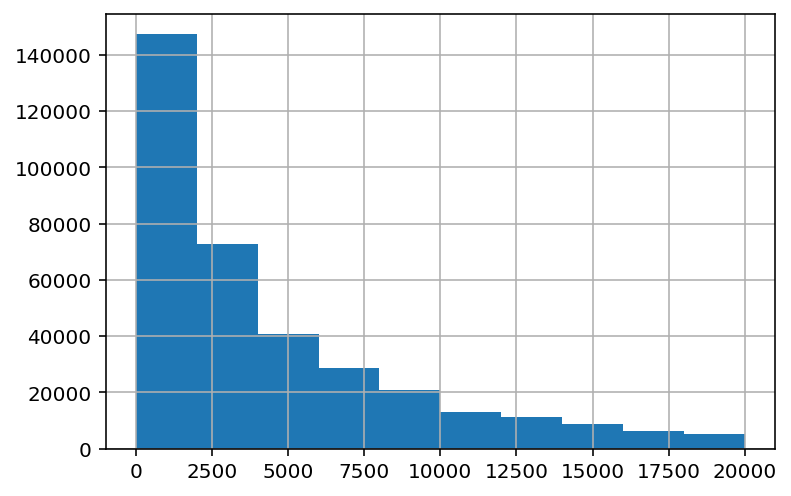

In [10]:
df_cars['Price'].hist();

### Conclusion

We have the dataframe with 354369 rows and 16 columns:
- We have missing values. So we need to them.
- We have only 0's in 'NumberOfPictures'. And we don't need 'DateCrawled', 'DateCreated', 'LastSeen','RegistrationMonth', 'Power'. Drop these columns.
- We have zeros in "Price" column. Drop it.

### 1.2. Data preprocessing

*Drop NaN and zeros*

In [11]:
df_cars['Price'].replace(0, np.nan, inplace=True)
df_cars.dropna(inplace=True)

*Drop 'NumberOfPictures', 'Power', 'DateCrawled', 'DateCreated', 'RegistrationMonth', 'LastSeen' columns*

In [12]:
df_cars.drop(columns=['NumberOfPictures', 'Power', 'DateCrawled', 'DateCreated', 'RegistrationMonth', 'LastSeen'], inplace=True)

*Check the duplicates*

In [13]:
# check the duplicates
df_cars.duplicated().sum()

20210

*Drop duplicates*

In [14]:
df_cars.drop_duplicates(inplace = True)

*Check the values*

In [15]:
df_cars.shape[0]

222218

*Check the values*

In [16]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222218 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             222218 non-null  float64
 1   VehicleType       222218 non-null  object 
 2   RegistrationYear  222218 non-null  int64  
 3   Gearbox           222218 non-null  object 
 4   Model             222218 non-null  object 
 5   Mileage           222218 non-null  int64  
 6   FuelType          222218 non-null  object 
 7   Brand             222218 non-null  object 
 8   NotRepaired       222218 non-null  object 
 9   PostalCode        222218 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 18.6+ MB


### 1.3. Feature and target preparation

*Create features and target datasets*

In [17]:
# create features and target datasets
X = df_cars.drop(['Price'], axis=1)
y = df_cars['Price']

In [18]:
# look at the features
X.head()

,VehicleType,RegistrationYear,Gearbox,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode
3,small,2001,manual,golf,150000,petrol,volkswagen,no,91074
4,small,2008,manual,fabia,90000,gasoline,skoda,no,60437
5,sedan,1995,manual,3er,150000,petrol,bmw,yes,33775
6,convertible,2004,manual,2_reihe,150000,petrol,peugeot,no,67112
10,sedan,2004,manual,3_reihe,150000,petrol,mazda,no,96224


*Make One-Hot Encoding of categorical features with "drop_first" parameter*

In [19]:
# use pd.get_dummies for OHE with "drop_first"
X_ohe = pd.get_dummies(X, drop_first=True)

*Scale the features*

In [20]:
# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X_ohe)

*Split the data into training and validation sets*

In [21]:
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

## 2. Model training

*Create RandomizedSearchCV func*

In [22]:
def random_search_cv(model, parameters, X_train, y_train):
    # create "RandomizedSearchCV" class with scoring for rmse
    random_search = RandomizedSearchCV(model, parameters, cv=5)
    
    # fit train data
    random_search.fit(X_train, y_train)
    
    # print best parameters
    print('Best parameters:', random_search.best_params_)
    
    # return the best model after "GridSearchCV"
    return random_search.best_estimator_

Train different models with various hyperparameters. We'll try the following models: 
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- LightGBM
- CatBoost
- XGBoost

### 2.1. LinearRegression

In [23]:
lr_model = LinearRegression() # create model class

In [24]:
%%time
lr_model.fit(X_train, y_train) # fit the model

CPU times: user 14.1 s, sys: 3.59 s, total: 17.7 s
Wall time: 17.6 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
%%time
y_pred_train = lr_model.predict(X_train) # predict values for train data

CPU times: user 180 ms, sys: 16.8 ms, total: 197 ms
Wall time: 194 ms


In [26]:
%%time
y_pred_test = lr_model.predict(X_test) # predict values for test data

CPU times: user 85.3 ms, sys: 26.6 ms, total: 112 ms
Wall time: 101 ms


In [27]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 2697.14
RMSE_test: 2694.49


### 2.2. DecisionTreeRegressor

In [28]:
dt_model = DecisionTreeRegressor(random_state=42) # create model class
params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 40, 10), 
          'min_samples_leaf': range(1, 20, 5)}

In [29]:
%%time
best_model = random_search_cv(dt_model, params, X_train, y_train) # fit the model

Best parameters: {'min_samples_split': 32, 'min_samples_leaf': 11, 'max_depth': 8}
CPU times: user 2min 51s, sys: 7.52 s, total: 2min 59s
Wall time: 2min 59s


In [30]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 141 ms, sys: 52 ms, total: 193 ms
Wall time: 203 ms


In [31]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 60.5 ms, sys: 8.26 ms, total: 68.8 ms
Wall time: 82.7 ms


In [32]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 2451.4
RMSE_test: 2473.11


### 2.3. RandomForestRegressor

In [33]:
rf_model = RandomForestRegressor(max_depth=9, random_state=42) # create model class
params = {'n_estimators': range(10, 50, 10)}

In [34]:
%%time
best_model = random_search_cv(rf_model, params, X_train, y_train) # fit the model

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters: {'n_estimators': 40}
CPU times: user 32min 41s, sys: 4.26 s, total: 32min 45s
Wall time: 32min 48s


In [35]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 1.43 s, sys: 56.1 ms, total: 1.48 s
Wall time: 1.59 s


In [36]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 478 ms, sys: 20 ms, total: 498 ms
Wall time: 508 ms


In [37]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 2292.63
RMSE_test: 2327.26


### 2.4. GradientBoostingRegressor

In [38]:
gbr_model = GradientBoostingRegressor(max_depth=9, n_estimators=40, random_state=42) # create model class
params = {'learning_rate': [.2, .4, .5]}

In [39]:
%%time
best_model = random_search_cv(gbr_model, params, X_train, y_train) # fit the model

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters: {'learning_rate': 0.4}
CPU times: user 1h 48min 10s, sys: 6.23 s, total: 1h 48min 17s
Wall time: 1h 49min 1s


In [40]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 872 ms, sys: 51.9 ms, total: 924 ms
Wall time: 940 ms


In [41]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 318 ms, sys: 20 ms, total: 338 ms
Wall time: 348 ms


In [42]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 1629.59
RMSE_test: 1837.32


### 2.5. LightGBM 

In [43]:
lgb_model = lgb.LGBMRegressor(max_depth=9, n_estimators=40, random_state=42) # create model class
params = {'learning_rate': [.2, .4, .5]}

In [44]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=9,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
%%time
best_model = random_search_cv(lgb_model, params, X_train, y_train) # fit the model

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters: {'learning_rate': 0.5}
CPU times: user 5min 35s, sys: 11.1 s, total: 5min 47s
Wall time: 5min 48s


In [46]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 1.57 s, sys: 4 ms, total: 1.57 s
Wall time: 1.56 s


In [47]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 549 ms, sys: 105 µs, total: 549 ms
Wall time: 589 ms


In [48]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 1840.38
RMSE_test: 1889.2


### 2.6. CatBoost 

In [59]:
cat_model = CatBoostRegressor(max_depth=9, iterations=50, random_state=42) # create model class
params = {'learning_rate': [.2, .4, .5]}

In [60]:
%%time
best_model = random_search_cv(cat_model, params, X_train, y_train) # fit the model

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 4095.6967698	total: 161ms	remaining: 7.91s
1:	learn: 3649.0352133	total: 355ms	remaining: 8.53s
2:	learn: 3319.8090619	total: 468ms	remaining: 7.33s
3:	learn: 3069.7666122	total: 659ms	remaining: 7.58s
4:	learn: 2850.0558172	total: 857ms	remaining: 7.71s
5:	learn: 2694.4510310	total: 1.05s	remaining: 7.7s
6:	learn: 2585.2621179	total: 1.16s	remaining: 7.15s
7:	learn: 2490.7640703	total: 1.36s	remaining: 7.13s
8:	learn: 2421.6897388	total: 1.55s	remaining: 7.07s
9:	learn: 2362.4662837	total: 1.75s	remaining: 7s
10:	learn: 2320.8748658	total: 1.86s	remaining: 6.61s
11:	learn: 2290.5438648	total: 2.05s	remaining: 6.49s
12:	learn: 2261.9636960	total: 2.24s	remaining: 6.38s
13:	learn: 2233.9358680	total: 2.35s	remaining: 6.05s
14:	learn: 2212.0864734	total: 2.54s	remaining: 5.94s
15:	learn: 2194.2753195	total: 2.66s	remaining: 5.64s
16:	learn: 2174.5578455	total: 2.85s	remaining: 5.53s
17:	learn: 2163.4939937	total: 3.04s	remaining: 5.41s
18:	learn: 2152.3769679	total: 3.15s	remai

In [61]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 11.4 s, sys: 148 ms, total: 11.6 s
Wall time: 11.6 s


In [62]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 3.95 s, sys: 52.1 ms, total: 4 s
Wall time: 4.08 s


In [63]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 1832.08
RMSE_test: 1866.24


### 2.7. XGBoost 

In [54]:
xgb_model = XGBRegressor(max_depth=9, n_estimators=40, random_state=42) # create model class
params = {'learning_rate': [.2, .4, .5]}

In [55]:
%%time
best_model = random_search_cv(xgb_model, params, X_train, y_train) # fit the model

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[01:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:18:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [56]:
%%time
y_pred_train = best_model.predict(X_train) # predict values for train data

CPU times: user 1.41 s, sys: 308 ms, total: 1.72 s
Wall time: 1.73 s


In [57]:
%%time
y_pred_test = best_model.predict(X_test) # predict values for test data

CPU times: user 483 ms, sys: 108 ms, total: 591 ms
Wall time: 600 ms


In [58]:
# print RMSE for train and test
print('RMSE_train:', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 2))
print('RMSE_test:', round(mean_squared_error(y_test, y_pred_test) ** 0.5, 2))

RMSE_train: 1677.11
RMSE_test: 1847.21


## 3. Model analysis

XGBoost model has the bes RMSE (RMSE_test: 1847.21), but low train speed (32min 57s). LightGBM has similar RMSE (RMSE_test: 1889.2), but train speed more fast (5min 48s). CatBoost has better RMSE than LightGBM (RMSE_test: 1866.24), but speed is lower (7min 24s). 

## 4. Conclusion

LightGBM is the best with these hyperparameters.